# Enroll-O-Matic

First, let's import some useful features of various packages, etc.

In [28]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib import colormaps as cm
from sklearn.linear_model import LinearRegression
import tqdm

Now, let's create a class that implements the idea of a "College"; that is, it has enrollment.

In [16]:
class College:
    def __init__(self,
                 config=dict(
                     initial_cohorts=[0,0,0,0,0],
                     initial_retention_rates=[1,1,1,1],
                     retention_rate_uncertainties=[0,0,0,0],
                     new_enrollment_uncertainty=0,
                     slope=0,
                     duration=20,
                     colormapname='winter')
                ):
        self.C=np.array(config['initial_cohorts']).reshape(len(config['initial_cohorts']),1)
        self.r=np.array(config['initial_retention_rates'])
        self.dr=np.array(config['retention_rate_uncertainties'])
        self.dC=config['new_enrollment_uncertainty']
        self.DeltaE=config['slope']
        self.duration=config['duration']
        self.nyears=len(self.C)
        self.cm=cm[config['colormapname']]

    def E(self):
        """ Compute and return the current total enrollment """
        return self.C[:,-1].sum()
    
    def __next__(self):
        """ Compute the cohort populations for next year based on current-year values """
        # update the "actual" retention values randomly
        for i in range(self.nyears-1):
            self.r[i]+=norm.rvs(loc=0.0,scale=self.dr[i])
            self.r[i]=min(self.r[i],1.0)
        # calculated error in predicted first-year enrollment
        eC=norm.rvs(loc=0.0,scale=self.dC)
        # calculate current total enrollment
        En=self.E()
        # calculate new cohort values for sophomores and up
        tC=np.zeros(self.nyears)
        tC[1:]=self.C[:,-1][:-1]*self.r
        # calculate the tuned value for the freshman class
        tC[0]=self.DeltaE+En-tC.sum()+eC
        self.C=np.concatenate((self.C,np.array([tC]).reshape(-1,1).round(0)),axis=1)
    
    def run(self):
        for _ in range(self.duration):
            next(self)
        x=np.arange(self.duration+1).reshape(-1,1)
        y=self.C.sum(axis=0)
        model=LinearRegression()
        model.fit(x, y)
        self.slope=int(model.coef_[0])
        self.r2=model.score(x, y)
        self.y_pred_1=model.predict(x)
        return self
    
    def stackplot(self):
        fig,ax=plt.subplots(1,1)
        ax.stackplot(range(self.C.shape[1]),self.C,labels=['1','2','3','4','5'],colors=[self.cm(x/self.C.shape[0]) for x in range(self.C.shape[0])],alpha=0.5)
        ax.legend()
        ax.set_xlabel('year')
        ax.set_xticks(range(self.C.shape[1]))
        ax.set_xticklabels([str(int(x)) for x in range(self.C.shape[1])],rotation=90)
        ax.set_ylabel('total enrollment')
        ax.set_title(f'R2={self.r2:.3f} slope={int(self.slope)}')
        plt.show()


Let's create a scenario for a 4-year college with 1000 students in each cohort to start.  We'll assume

* initial year-to-year retention rates are 0.88 +/ 0.02
* new enrollment uncertainty is +/- 40

We seek a 20-year trend in which the total enrollment decreases by -170

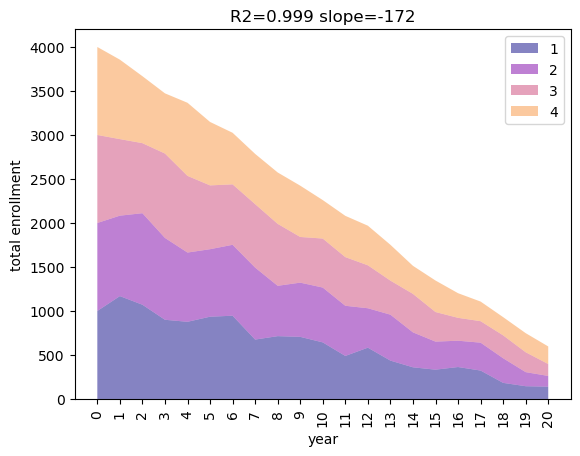

In [17]:
config=dict(
    initial_cohorts=[1000,1000,1000,1000],
    initial_retention_rates=[0.88,0.88,0.88],
    retention_rate_uncertainties=[0.02,0.02,0.02],
    new_enrollment_uncertainty=40,
    slope=-170,
    duration=20,
    colormapname='plasma')
C=College(config).run()
C.stackplot()

This is a stochastic simulation, so let's run a second instantiation

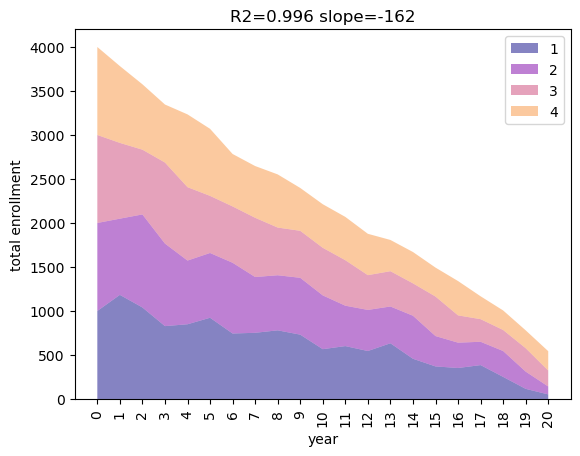

In [18]:
C=College(config).run()
C.stackplot()

Let's simulate a "perfect college"

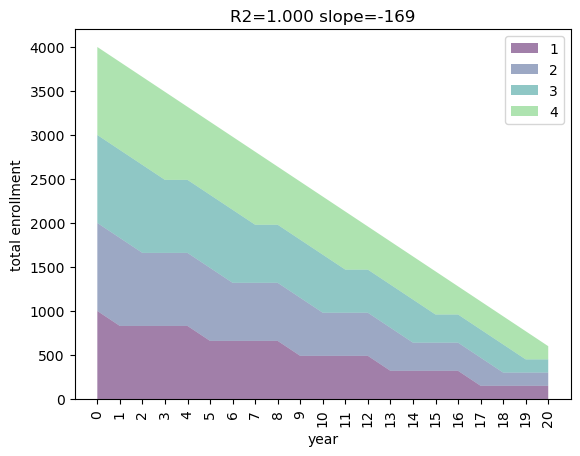

In [20]:
config=dict(
    initial_cohorts=[1000,1000,1000,1000],
    initial_retention_rates=[1.0,1.0,1.0],
    retention_rate_uncertainties=[1.e-6,1.e-6,1.e-6],
    new_enrollment_uncertainty=1.e-6,
    slope=-170,
    duration=20,
    colormapname='viridis')
C=College(config).run()
C.stackplot()

Here's a perfect 5-year college

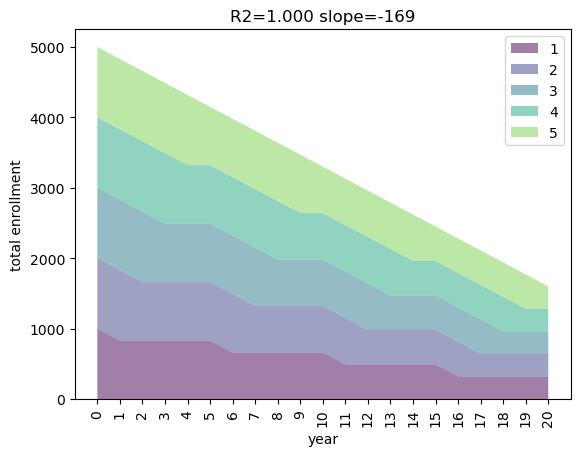

In [21]:
config=dict(
    initial_cohorts=[1000,1000,1000,1000,1000],
    initial_retention_rates=[1.0,1.0,1.0,1.0],
    retention_rate_uncertainties=[1.e-6,1.e-6,1.e-6,1.e-6],
    new_enrollment_uncertainty=1.e-6,
    slope=-170,
    duration=20,
    colormapname='viridis')
C=College(config).run()
C.stackplot()

Let's consider a different initial set of cohorts

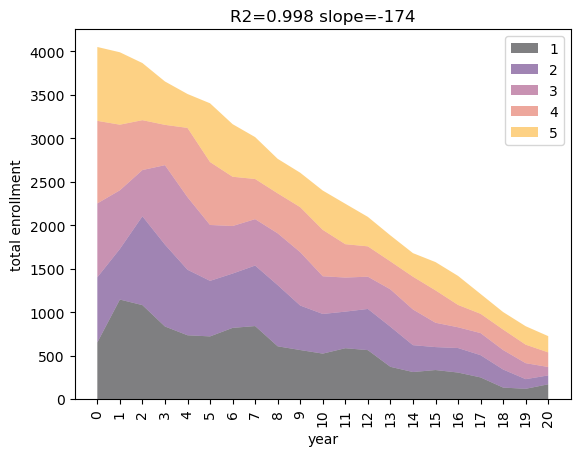

In [27]:
config=dict(
    initial_cohorts=[650,750,850,950,850],
    initial_retention_rates=[0.88,0.88,0.88,0.88],
    retention_rate_uncertainties=[0.02,0.02,0.02,0.02],
    new_enrollment_uncertainty=40,
    slope=-170,
    duration=20,
    colormapname='inferno')
C=College(config).run()
C.stackplot()

Wow!  Look how squiggly the first-year enrollment curve is!  Like a roller-coaster!  No one will suspect you are decreasing the total enrollment when the fist-year enrollment is so chaotic!  But that's the genius of Enroll-O-Matic!  The total enrollment is decreasing just as prescribed (plus or minus your ability to predict enrollment)!

The only thing that might be a giveaway is the clear periodicity in the enrollments, but don't worry!  The chances are decision makers at your university don't understand words like "periodicity" and therefore don't know how suspicious it is!

But I know you're thinking: "Come on.  A line doesn't mean the enrollment is being controlled."  Well, let's think that through.  Can we get some idea of the variability of the first-year enrollment that allows for linear decline in total enrollment for a given initial cohort?  We sure can!

100%|██████████| 10000/10000 [00:51<00:00, 193.55it/s]


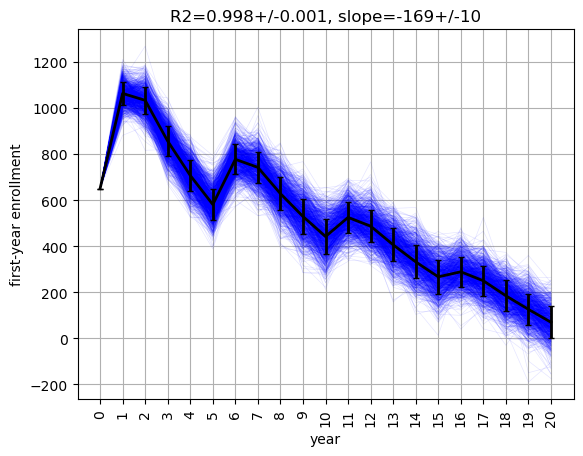

In [45]:
config=dict(
    initial_cohorts=[650,750,850,950,850],
    initial_retention_rates=[0.88,0.88,0.88,0.88],
    retention_rate_uncertainties=[0.02,0.02,0.02,0.02],
    new_enrollment_uncertainty=40,
    slope=-170,
    duration=20,
    colormapname='inferno')
years=np.arange(21)
trends=[]
R2=[]
slope=[]
for _ in tqdm.tqdm(range(10000)):
    C=College(config)
    C.run()
    R2.append(C.r2)
    slope.append(C.slope)
    trends.append(C.C[0,:])
trends=np.array(trends).round(0)
meantrend=trends.mean(axis=0).round(0)
stdtrend=trends.std(axis=0).round(0)
R2=np.array(R2)
slope=np.array(slope)

fig,ax=plt.subplots(1,1)
for t in trends[::10]:
    ax.plot(years,t,alpha=0.1,color='blue',lw=0.5)
ax.errorbar(years,meantrend,stdtrend,color='black',lw=2,capsize=2)
ax.set_xlabel('year')
ax.set_ylabel('first-year enrollment')
ax.set_xticks(years)
ax.set_xticklabels([str(int(x)) for x in years],rotation=90)
ax.grid(True)
ax.set_title(f'R2={R2.mean():.3f}+/-{R2.std():.3f}, slope={slope.mean():.0f}+/-{slope.std():.0f}')
plt.show()

Any one of these stochastic first-year enrollment trends gives a linear decline in total enrollment, but they are tightly clustered around the trend that gives a "perfectly" linear trend.  This makes it difficult to see how an *uncontrolled* first-year enrollment can lead to a linear total enrollment trend.